## Vector Search with [LanceDB](https://lancedb.com/) using [Voyage AI](https://www.voyageai.com/)'s Text and Multimodal Embeddings

**Voyage AI** embeddings provide high-precision, domain-specific vector representations across text and multimodal data, while **LanceDB** offers an ultra-fast, persistent vector database for efficient storage and retrieval. Together, It creates a powerful ecosystem for semantic search, enabling developers to build intelligent, context-aware applications with minimal computational overhead.

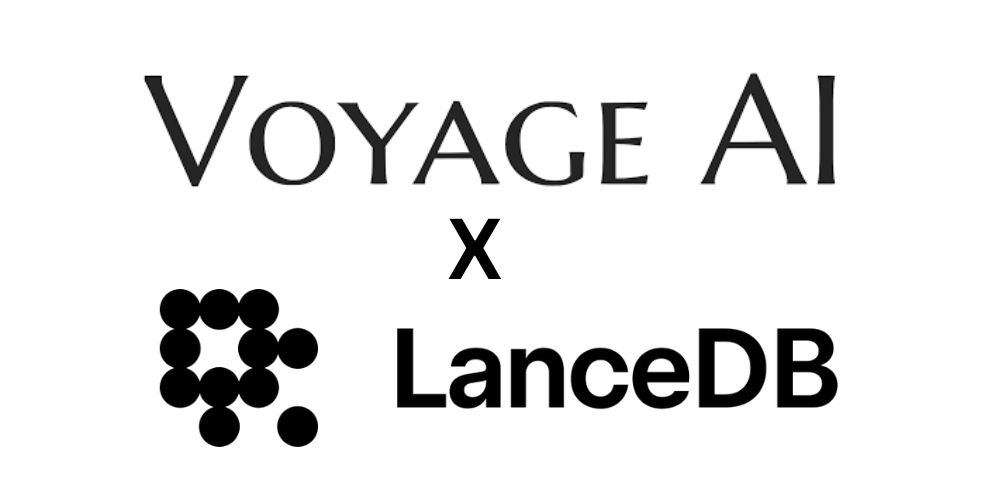

This notebook demonstrates a semantic search example where Voyage AI’s text and multimodal embeddings are used to create a powerful search system that integrates both text and images, enabling searches across both image and text data simultaneously.

## Install Dependencies

In [ ]:
!pip install voyageai lancedb datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.2/32.2 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load dataset
This example utilizes Google Research's dataset **Conceptual Captions**


### About Dataset
Dataset Summary
Conceptual Captions is a dataset consisting of ~3.3M images annotated with captions. In contrast with the curated style of other image caption annotations, Conceptual Caption images and their raw descriptions are harvested from the web, and therefore represent a wider variety of styles. More precisely, the raw descriptions are harvested from the Alt-text HTML attribute associated with web images. To arrive at the current version of the captions, we have developed an automatic pipeline that extracts, filters, and transforms candidate image/caption pairs, with the goal of achieving a balance of cleanliness, informativeness, fluency, and learnability of the resulting captions.

We'll be loading validation set of this dataset as it contains 15k records, You can try it with train set too, Just make sure you filter all the images and confirm that all the image urls are working(filtering reachable image url is time consuming step)

In [ ]:
from datasets import load_dataset

# Load validation split
ds = load_dataset(
    "google-research-datasets/conceptual_captions", split="validation"
).to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3318333 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15840 [00:00<?, ? examples/s]

In [ ]:
# check for column names in dataset
ds.columns

Index(['image_url', 'caption'], dtype='object')

### Set Voyage API KEY as env variable

Add your Voyage API key as a secret in Google Colab. If you don't have one, you can sign up for one here (with 200M free tokens): https://dash.voyageai.com

In [ ]:
import os

# set voyage key
os.environ["VOYAGE_API_KEY"] = "pa-...."

In [ ]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import EmbeddingFunctionRegistry
from PIL import Image
from typing import List, Union

## Voyage's Text model

In [ ]:
!pip install pyarrow

In [ ]:
import voyageai
import pyarrow as pa

vo = voyageai.Client()


class TextModel(LanceModel):
    caption: str
    image_url: str
    vector: Vector(1024)

Create **LanceDB table to index data** to do query search

This step may take sometime as data is getting ingested in batches into LanceDB

In [ ]:
db = lancedb.connect("lancedb")
tbl = db.create_table("lancedb_voyage_text", schema=TextModel, mode="overwrite")

batch_size = 128
num_batches = len(ds) // batch_size + (1 if len(ds) % batch_size != 0 else 0)

# adding data in batches
for i in range(num_batches):
    batch = ds.iloc[i * batch_size : (i + 1) * batch_size]
    batch = batch.copy()
    captions = batch["caption"].tolist()

    embeddings = vo.embed(captions, model="voyage-3", input_type="document").embeddings
    batch.loc[:, "vector"] = embeddings
    tbl.add(batch)

In [ ]:
from io import BytesIO
import matplotlib.pyplot as plt
import requests


def show_images(results):
    """
    Helper function to show top 3 images of results
    """
    count = 0
    for i in range(len(results)):
        if count >= 3:
            break

        try:
            response = requests.get(results["image_url"][i], timeout=1)
            if response.status_code == 200:
                count += 1
                print("Caption: ", results["caption"][i])
                img = Image.open(BytesIO(response.content))
                plt.imshow(img)
                plt.axis("off")
                plt.show()
        except Exception as e:
            pass

Query indexed data with Voyage's **voyage-3** text model

---



Caption:  cat on a vintage chair in a sunny room


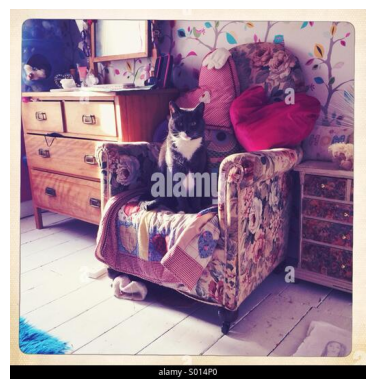

Caption:  young cute cat resting on leather sofa .


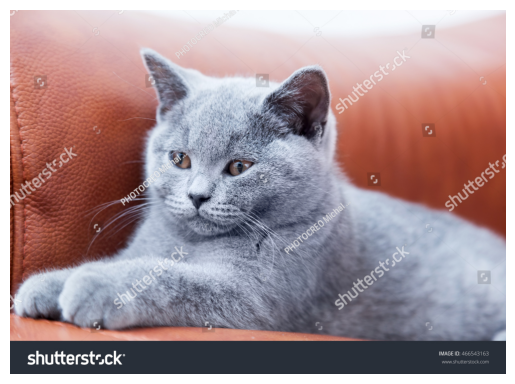

Caption:  cat lying down on the floor with paws up


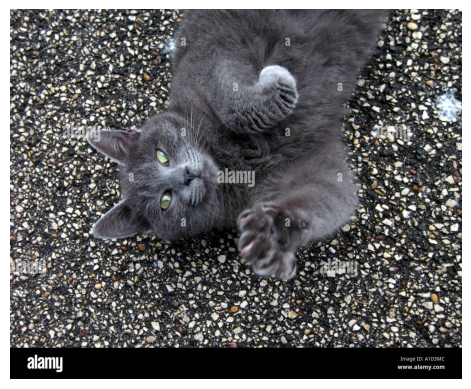

In [ ]:
query = "a cat sitting on a mat"
embedding = vo.embed(query, model="voyage-3", input_type="query").embeddings
# querying top-5
results = tbl.search(embedding).limit(10).to_pandas()
show_images(results)

Caption:  mountains soar above villages along the shores


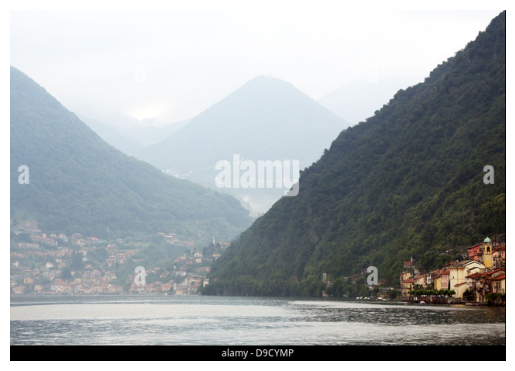

Caption:  snow on the distant mountains across the bay


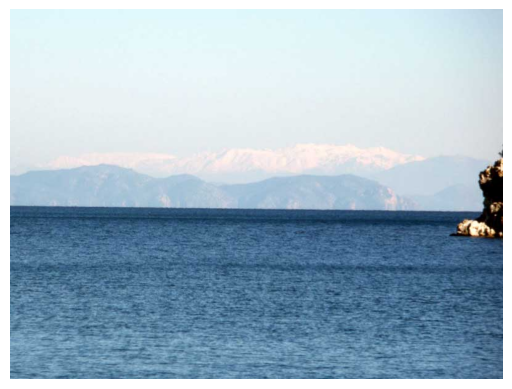

Caption:  unique natural landscape the shore .


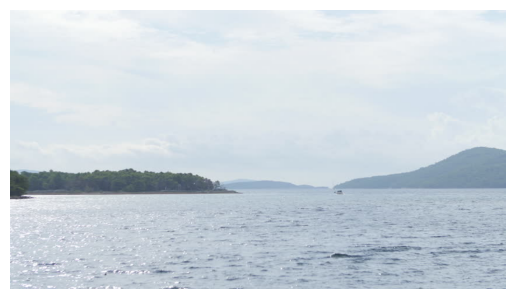

In [ ]:
query = "Where the mountains meet the sea, that's where beauty of nature's embrace."

embedding = vo.embed(query, model="voyage-3", input_type="query").embeddings
# querying top-5
results = tbl.search(embedding).limit(10).to_pandas()
show_images(results)

## Voyage's Multimodal model

In [ ]:
class Multimodal(LanceModel):
    caption: str
    image_url: str
    vector: Vector(1024)

Create **LanceDB table with multimodal model to index data** to do query search with either text or image

This step may take sometime as data is getting ingested in batches into LanceDB

In [ ]:
db = lancedb.connect("lancedb")
multimodal_tbl = db.create_table(
    "lancedb_voyage_multimodal", schema=TextModel, mode="overwrite"
)

batch_size = 128
num_batches = len(ds) // batch_size + (1 if len(ds) % batch_size != 0 else 0)

# adding data in batches
for i in range(num_batches):
    batch = ds.iloc[i * batch_size : (i + 1) * batch_size]
    batch = batch.copy()
    captions = [[caption] for caption in batch["caption"].tolist()]

    embeddings = vo.multimodal_embed(captions, model="voyage-multimodal-3").embeddings
    batch.loc[:, "vector"] = embeddings
    multimodal_tbl.add(batch)

Query indexed data with Voyage's **voyage-multimodal-3** model using text and image both

---



Caption:  in good company : person poses on the red carpet alongside actors


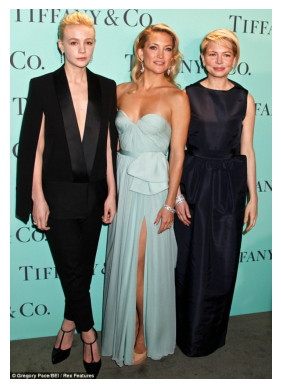

Caption:  celebrity at person on the gala .


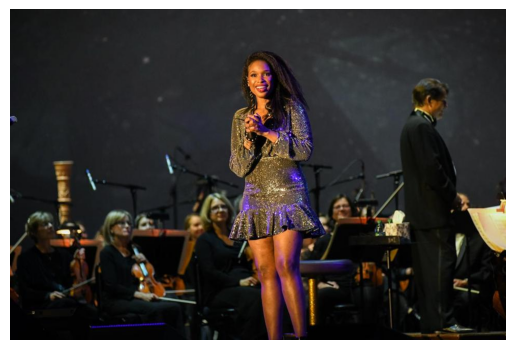

Caption:  on the red carpet for the premiere of her movie


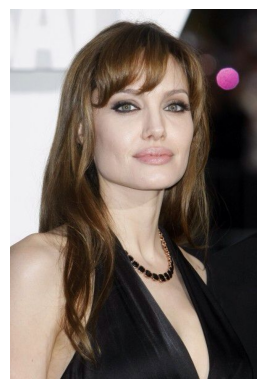

In [ ]:
query = "Celebrities on Red carpet"

embedding = vo.multimodal_embed([[query]], model="voyage-multimodal-3").embeddings[0]
# querying top-5
results = multimodal_tbl.search(embedding).limit(10).to_pandas()
show_images(results)

Now let's query using an image using Voyage's multimodal model

Caption:  on the red carpet for the premiere of her movie


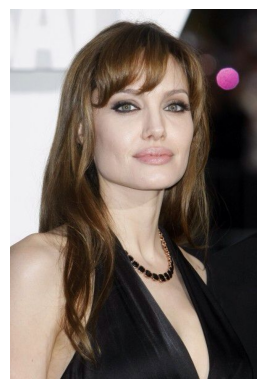

Caption:  model modeling an evening gown .


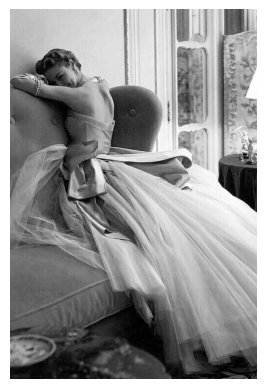

Caption:  noble person in a glamorous maxi dress during her tour .


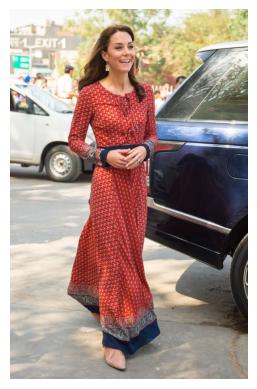

In [ ]:
query_image_url = "https://assets.vogue.in/photos/6470e7786ecd9ba721aba1a6/2:3/w_1920,c_limit/GettyImages-1493533798.jpg"
response = requests.get(query_image_url, timeout=2)
query_image = Image.open(BytesIO(response.content))

embedding = vo.multimodal_embed(
    [[query_image]], model="voyage-multimodal-3"
).embeddings[0]
# querying top-5
results = multimodal_tbl.search(embedding).limit(10).to_pandas()
show_images(results)

### Hope you had fun working with Voyage's Text and Multimodal model and LanceDB.